In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import plotting

In [5]:
import scipy
from iminuit import cost
from iminuit import Minuit

In [6]:
import hist

In [7]:
plt.style.use(["science", "notebook"])

In [8]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.formatter.limits"] = -5, 4
plt.rcParams["figure.figsize"] = 6, 4
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [9]:
data_path = "/eos/experiment/sndlhc/users/olantwin/advsnd/2024/07/nu12/CCDIS/"

In [10]:
df = pd.read_csv(data_path + "features_CNN_1d_99987.csv")

In [11]:
X = np.load(data_path + "images_1d_99987.npy")[:, :, np.newaxis]

In [12]:
X /= X.max()

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import tensorflow.keras.backend as K

2024-08-21 11:38:59.999092: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 11:39:00.078530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
from tensorflow.keras.utils import plot_model

In [15]:
K.set_image_data_format("channels_last")

In [16]:
y = df["start_z"].values

In [17]:
y = (y + 235) / 155

In [18]:
def y_to_z(y):
    return (y * 155) - 235

In [19]:
y_to_z(y)

array([-174.55841064, -203.98649597, -204.99772644, ..., -216.61203003,
       -135.82762146, -175.01226807])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
input_shape = (200, 1)

In [22]:
from tensorflow.keras.layers import Conv1D

In [23]:
from tensorflow.keras.layers import MaxPooling1D

In [24]:
from tensorflow.keras import Sequential

In [50]:
model_name = "CNN_1d_finsteraarhorn"

In [73]:
model = Sequential(
    [
        Input(input_shape),
        Conv1D(
            16,
            kernel_size=(4),
            padding="same",
            activation="elu",
        ),
        Conv1D(
            16,
            kernel_size=(4),
            padding="same",
            activation="elu",
        ),
        MaxPooling1D(2),  # Pool planes in station
        Conv1D(
            16,
            kernel_size=(4),
            padding="same",
            activation="elu",
        ),
        MaxPooling1D(3),
        Dropout(0.5),
        Conv1D(
            16,
            kernel_size=(4),
            padding="same",
            activation="elu",
        ),
        Flatten(),
        Dense(1),
    ],
    name=model_name,
)

In [74]:
model.compile(optimizer="Adam", loss="mse", metrics=["mae"])

In [75]:
model.summary()

Model: "CNN_1d_finsteraarhorn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 200, 16)           80        
                                                                 
 conv1d_13 (Conv1D)          (None, 200, 16)           1040      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 100, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 100, 16)           1040      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 33, 16)            0         
 g1D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 33, 16)  

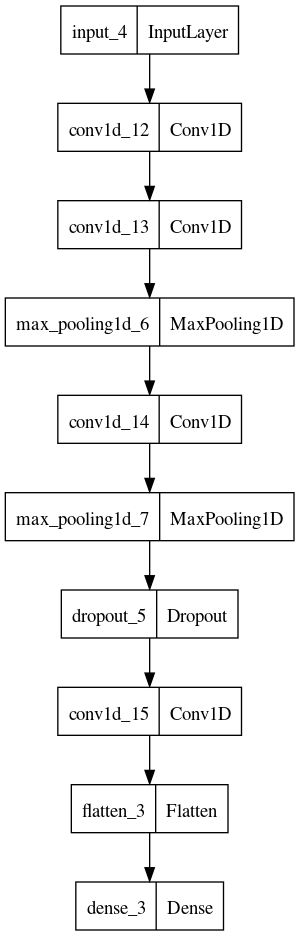

In [76]:
plot_model(model)

In [77]:
history_df = None

In [78]:
fit_result = model.fit(x=X_train, y=y_train, batch_size=128, epochs=100)

Epoch 1/100
586/586 [==============================] - 5s 5ms/step - loss: 0.0289 - mae: 0.1241
Epoch 2/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0127 - mae: 0.0821
Epoch 3/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0076 - mae: 0.0620
Epoch 4/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0056 - mae: 0.0523
Epoch 5/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0042 - mae: 0.0455
Epoch 6/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0034 - mae: 0.0409
Epoch 7/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0027 - mae: 0.0361
Epoch 8/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0024 - mae: 0.0337
Epoch 9/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0020 - mae: 0.0308
Epoch 10/100
586/586 [==============================] - 3s 5ms/step - loss: 0.0018 - mae: 0.0292
Epoch 11/100
586/586 [=================

In [79]:
history_df = pd.concat([history_df, pd.DataFrame(fit_result.history)])

In [80]:
model.save(f"{model_name}_n{len(y)}_e{len(history_df)}.keras")

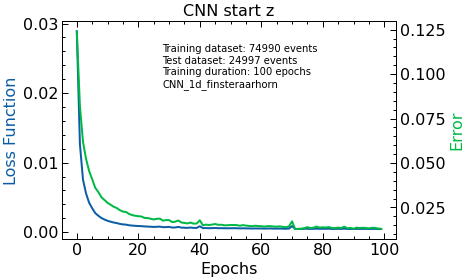

In [81]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title("CNN start z")
ax1.plot(history_df["loss"].values, color=colors[0])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss Function", color=colors[0])
ax2.plot(history_df["mae"].values, color=colors[1])
ax2.set_ylabel("Error", color=colors[1])
plt.text(
    0.3,
    0.7,
    f"Training dataset: {len(y_train)} events\n"
    f"Test dataset: {len(y_test)} events\n"
    f"Training duration: {len(history_df)} epochs\n{model_name}",
    transform=ax1.transAxes,
)
plt.savefig(f"plots/convergence_{model_name}_n{len(y)}_e{len(history_df)}.pdf")
plt.savefig(f"plots/convergence_{model_name}_n{len(y)}_e{len(history_df)}.png")

In [82]:
y_pred = model.predict(x=X_test)

782/782 [==============================] - 2s 2ms/step


In [83]:
z_pred = y_to_z(y_pred)

In [84]:
h = hist.Hist.new.Regular(20, -5, +5, name=r"𝛥z [cm]").Double()

In [85]:
h.fill(np.squeeze(z_pred) - np.squeeze(y_to_z(y_test)))

Hist(Regular(20, -5, 5, name='𝛥z [cm]'), storage=Double()) # Sum: 23711.0 (24997.0 with flow)

In [86]:
entries, edges = h.to_numpy()

In [87]:
def residual_model(x, mu, sigma):
    return scipy.stats.norm.cdf(x, mu, sigma)

In [88]:
m = Minuit(cost.BinnedNLL(entries, edges, residual_model), 0, 25)

In [89]:
res = m.migrad()

In [90]:
res

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1094 (χ²/ndof = 60.8)      │              Nfcn = 89               │
│ EDM = 1.74e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  -0.790   │   0.011   │            │            │         │         │       │
│ 1 │ sigma │   1.650   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000116        0 │
│ sigma │        0 5.83e-05 │
└───────┴───────────────────┘

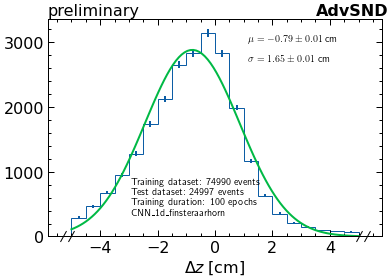

In [91]:
h.plot()
plt.xlabel(r"$\Delta z\;[\mathrm{cm}]$")
plot_range = edges[0], edges[-1]
x = np.linspace(*plot_range, 100)
best_fit = scipy.stats.norm(res.params[0].value, res.params[1].value)
# best_fit = scipy.stats.norm(0.044, 2.83) # TODO take from fit
n_bins = len(entries)
binsize = (plot_range[1] - plot_range[0]) / n_bins
scale = h.sum() / (best_fit.cdf(plot_range[1]) - best_fit.cdf(plot_range[0])) * binsize
plt.plot(x, scale * best_fit.pdf(x))
ax = plt.gca()
# plt.text(0.6, 0.9, r"$\mu = 0.044 $\;cm", transform=ax.transAxes, usetex=True)
plt.text(
    0.6,
    0.9,
    rf"$\mu = {res.params[0].value:.2f} \pm {res.params[0].error:.2f}$\;cm",
    transform=ax.transAxes,
    usetex=True,
)
plt.text(
    0.25,
    0.1,
    f"Training dataset: {len(y_train)} events\n"
    f"Test dataset: {len(y_test)} events\n"
    f"Training duration: {len(history_df)} epochs\n{model_name}",
    transform=ax.transAxes,
    usetex=True,
)
# plt.text(0.6, 0.81, r"$\sigma = 2.83 $\;cm", transform=ax.transAxes, usetex=True)
plt.text(
    0.6,
    0.81,
    rf"$\sigma = {res.params[1].value:.2f} \pm {res.params[1].error:.2f}$\;cm",
    transform=ax.transAxes,
    usetex=True,
)
plotting.watermark()
plt.savefig(f"plots/h_dz_{model_name}_n{len(y)}_e{len(history_df)}.pdf")
plt.savefig(f"plots/h_dz_{model_name}_n{len(y)}_e{len(history_df)}.png")